In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/dabuttare/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
n_rows = 3
n_cols = 3
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 3x3, per un totale di 9 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

"""
with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

matrix[0][0].Recover_VIPA(x_VIPA, y_VIPA)
"""
count = 0
for ii in range(len(rows)):
    for jj in range(len(cols)):
        #print(str((ii,jj)))
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [4]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


In [5]:
for (ii,jj) in boni:
    print('{:3.2f}\t{:3.2f}\n'.format(len(matrix[ii][jj].x_freq),len(matrix[ii][jj].y_markov_fit)))

105.00	105.00

104.00	104.00

105.00	105.00

106.00	106.00

105.00	105.00

105.00	105.00

105.00	105.00

105.00	105.00

104.00	104.00



In [6]:
#Parametri di Interesse per analisi

too_bad = ()
too_good  = ()
omega_too_high =  ()
gamma_too_bad = ()
omega_max = 8.2
gamma_max = 0.35
cost_max = 1000
cost_min = 50

print('Ho trovato per i dati in {} :\n'.format(now_path))


too_bad = Get_Bad_Elements(matrix, boni, cost_max)
too_good = Get_Good_Elements(matrix, boni, cost_min)
omega_too_high = Whose_Param_Too_High('Omega', omega_max, 'markov', matrix, boni)
gamma_too_high = Whose_Param_Too_High('Gamma', gamma_max, 'markov', matrix, boni)

print('{} elementi con Omega > {}\n'.format(len(omega_too_high), omega_max))
print('{} elementi con Gamma > {} \n'.format(len(gamma_too_high), gamma_max))

#aggiunte 
too_bad_gamma = ()
too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        too_bad_gamma += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        almost_height += ((ii,jj),)

print('{} elementi con Gamma con errore > {} \n'.format(len(gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))





Ho trovato per i dati in ../BRILLOUIN/TDP43/NO_ARS_12_02/dabuttare/ :

I found 0 bad elements 

I found 6 good elements 

0 elementi con Omega > 8.2

0 elementi con Gamma > 0.35 

0 elementi con Gamma con errore > 15 

0 elementi con offset > 30 



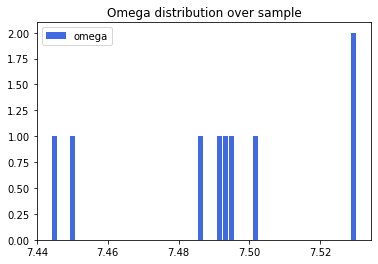

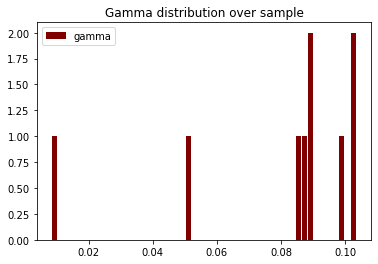

In [7]:
#HISTOGRAMs
plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni], bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'royalblue')
plt.legend()
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni], bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend()
plt.show()
plt.close()

Completata Parameter_Map per Omega
Ho trovato 0 elementi saturati


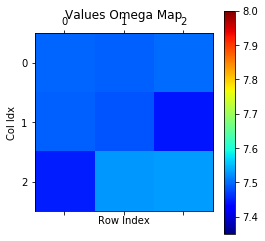

Completata Parameter_Map per Omega
Ho trovato 0 elementi saturati


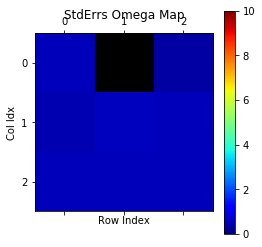

Completata Parameter_Map per Gamma
Ho trovato 0 elementi saturati


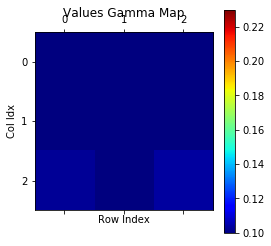

Completata Parameter_Map per Gamma
Ho trovato 0 elementi saturati


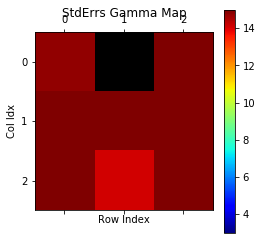

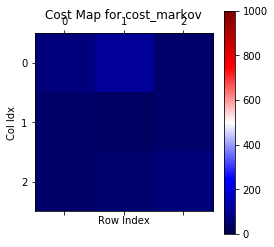

In [8]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

(0, 2)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.095121  7.502283  0.051082        0.168075     0.064783   
StdErrs   0.263560  0.025167  0.009704        2.104171     0.934160   
Initials  0.107378  7.571486  0.149129        0.119016     0.144893   

          delta_amplitude             A         mu      sigma     shift  \
Values           5.472499  4.464061e+03  -9.989592  15.784915  0.106779   
StdErrs       1098.687724  8.301768e+09  43.407259  64.849571  0.010381   
Initials         8.346143  4.797472e+03 -10.090497  15.800716  0.211020   

            offset  
Values    5.373154  
StdErrs   4.488720  
Initials -0.310388  


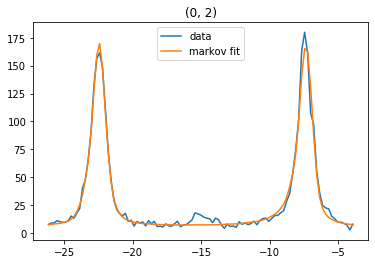

(0, 1)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.098590  7.492309  0.008292        1.439881     0.001134   
StdErrs        NaN       NaN       NaN             NaN          NaN   
Initials  0.095121  7.502283  0.051082        0.168075     0.064783   

          delta_amplitude            A         mu      sigma     shift  \
Values         163.992861  5299.390917 -10.089488  15.800700  0.146668   
StdErrs               NaN          NaN        NaN        NaN       NaN   
Initials         5.472499  4464.060542  -9.989592  15.784915  0.106779   

            offset  
Values    7.788113  
StdErrs        NaN  
Initials  5.373154  


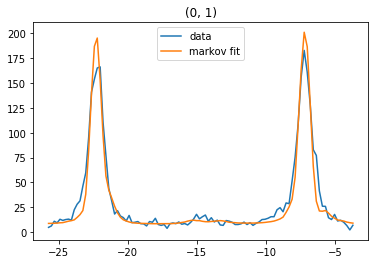

(0, 0)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.086742  7.495424  0.099802        0.624206     0.013379   
StdErrs   0.208949  0.039895  0.014761        0.000421     0.001451   
Initials  0.010000  7.478667  0.100000        0.000000     0.100000   

          delta_amplitude             A         mu      sigma     shift  \
Values          12.971772  6.305920e+03 -10.100700  15.960481  0.152199   
StdErrs          6.766563  1.172636e+10  39.030472  56.583577  0.037058   
Initials         1.000000  5.261980e+03 -10.202727  15.976457  0.000000   

            offset  
Values    5.144518  
StdErrs   1.574025  
Initials  0.000000  


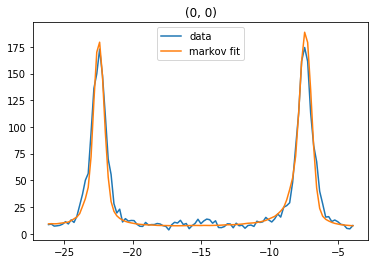

(1, 0)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.082975  7.492550  0.086883        0.624245     0.014293   
StdErrs   0.186576  0.034373  0.015312        0.000322     0.001377   
Initials  0.086742  7.495424  0.099802        0.624206     0.013379   

          delta_amplitude             A         mu      sigma     shift  \
Values          12.891137  5.044737e+03 -10.201707  15.976441  0.115592   
StdErrs          6.110180  7.979355e+09  35.207964  53.439257  0.029114   
Initials        12.971772  6.305920e+03 -10.100700  15.960481  0.152199   

            offset  
Values    7.891754  
StdErrs   1.518483  
Initials  5.144518  


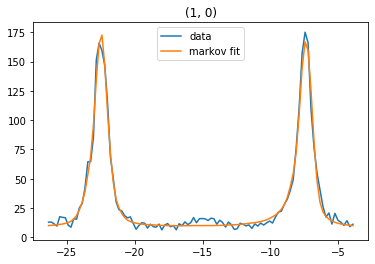

(1, 1)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.083382  7.486980  0.090020        0.624137     0.013085   
StdErrs   0.201882  0.042764  0.013957        0.000453     0.001528   
Initials  0.082975  7.492550  0.086883        0.624245     0.014293   

          delta_amplitude             A         mu      sigma     shift  \
Values          13.484451  4.035889e+03 -10.099690  15.960465  0.158643   
StdErrs          7.195562  9.874172e+09  39.339176  57.056540  0.037460   
Initials        12.891137  5.044737e+03 -10.201707  15.976441  0.115592   

            offset  
Values    7.554310  
StdErrs   1.610328  
Initials  7.891754  


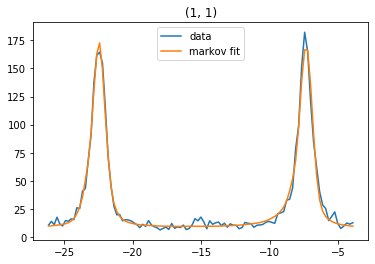

(1, 2)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.085400  7.444029  0.089411        0.624368     0.013240   
StdErrs   0.224913  0.039317  0.015511        0.000305     0.001290   
Initials  0.083382  7.486980  0.090020        0.624137     0.013085   

          delta_amplitude             A         mu      sigma     shift  \
Values          14.949105  4.843025e+03  -9.998693  15.944504  0.124806   
StdErrs          7.548701  8.113328e+09  43.540778  61.929547  0.034417   
Initials        13.484451  4.035889e+03 -10.099690  15.960465  0.158643   

            offset  
Values    7.672388  
StdErrs   1.779073  
Initials  7.554310  


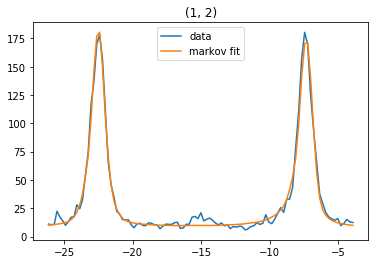

(2, 2)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.087477  7.530305  0.103674        0.623739     0.011960   
StdErrs   0.317431  0.039128  0.017532        0.000700     0.001942   
Initials  0.085400  7.444029  0.089411        0.624368     0.013240   

          delta_amplitude             A         mu      sigma     shift  \
Values          18.293073  3.874429e+03  -9.898706  15.928560  0.194985   
StdErrs          7.785309  7.703219e+09  62.230771  82.817473  0.033918   
Initials        14.949105  4.843025e+03  -9.998693  15.944504  0.124806   

            offset  
Values    6.608085  
StdErrs   2.424521  
Initials  7.672388  


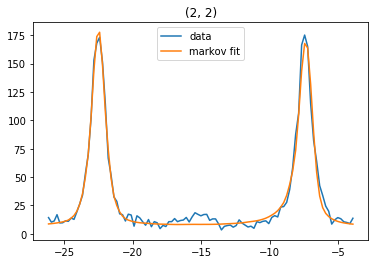

(2, 1)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.085348  7.528994  0.085718        0.624253     0.012598   
StdErrs   0.192144  0.039745  0.012114        0.000622     0.001849   
Initials  0.083382  7.486980  0.090020        0.624137     0.013085   

          delta_amplitude             A         mu      sigma     shift  \
Values          16.554595  3.229144e+03  -9.998693  15.944504  0.430428   
StdErrs          6.614961  5.122128e+09  39.431639  52.182151  0.032723   
Initials        13.484451  4.035889e+03 -10.099690  15.960465  0.158643   

            offset  
Values    6.856070  
StdErrs   1.658483  
Initials  7.554310  


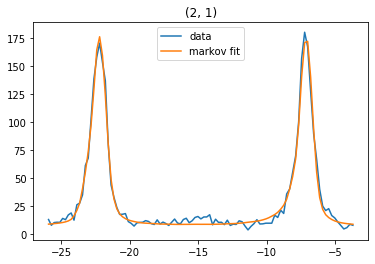

(2, 0)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.088637  7.450569  0.102863        0.624576     0.013172   
StdErrs   0.248992  0.039754  0.016681        0.000330     0.001291   
Initials  0.083382  7.486980  0.090020        0.624137     0.013085   

          delta_amplitude             A         mu      sigma     shift  \
Values          15.220687  3.228711e+03  -9.998693  15.944504  0.099835   
StdErrs          7.427165  7.454761e+09  46.108233  65.861193  0.036634   
Initials        13.484451  4.035889e+03 -10.099690  15.960465  0.158643   

            offset  
Values    6.000999  
StdErrs   1.842231  
Initials  7.554310  


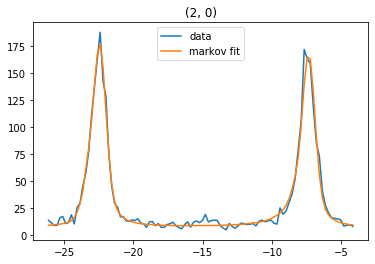

In [14]:
Plot_Elements_Spectrum(matrix, boni[0:10], fit = 'markov')

In [10]:
matrix[17][33].Markov_Fit_Params.values[0]

IndexError: tuple index out of range

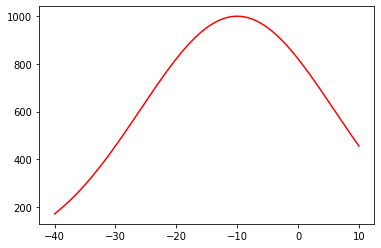

,mu,sigma
Values,-9.998693,15.944504
StdErrs,46.108233,65.861193
Initials,-10.099690,15.960465


In [11]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [18]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


Completata Parameter_Map per Omega
Ho trovato 0 elementi saturati


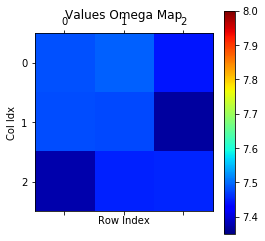

Completata Parameter_Map per Omega
Ho trovato 0 elementi saturati


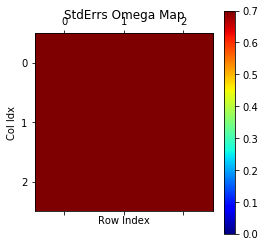

Completata Parameter_Map per Gamma
Ho trovato 0 elementi saturati


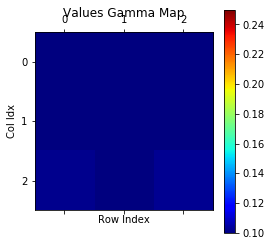

Completata Parameter_Map per Gamma
Ho trovato 0 elementi saturati


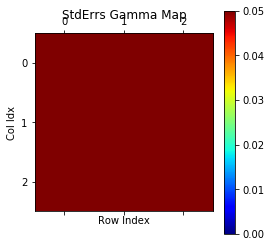

Completata Parameter_Map per tau
Ho trovato 0 elementi saturati


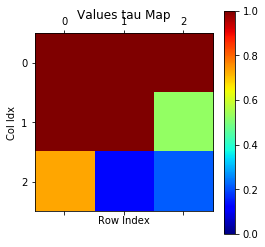

Completata Parameter_Map per tau
Ho trovato 0 elementi saturati


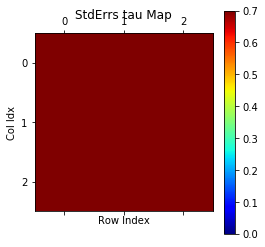

In [19]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

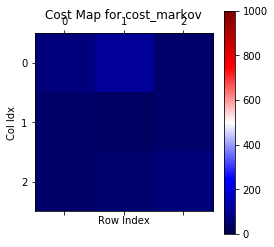

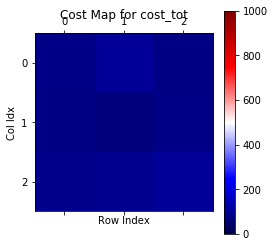

In [15]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


(0, 2)
                Co     Omega     Gamma         Delta            tau  \
Values    0.095216  7.445155  0.050571    110.024412     472.694771   
StdErrs   0.087346  7.029711  0.047380  90753.556499  378661.486594   
Initials  0.095121  7.502283  0.051082      0.051082       1.000000   

          delta_position  delta_width  delta_amplitude     shift    offset  
Values          2.000000     0.064135         5.527224  0.108419 -2.365374  
StdErrs         0.858465     0.035712         1.909553  0.009880  5.044708  
Initials        0.168075     0.064783         5.472499  0.106779  5.373154  


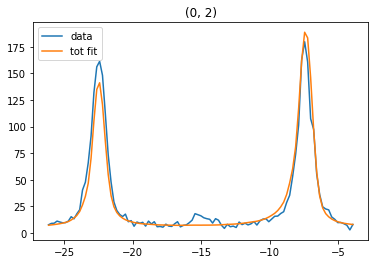

(0, 1)
                Co     Omega     Gamma     Delta        tau  delta_position  \
Values    0.098593  7.492307  0.008292  0.000010   1.701073       -1.901842   
StdErrs   0.013724  0.776072  0.029683  4.978445  54.218630   749690.872491   
Initials  0.098590  7.492309  0.008292  0.008292   1.000000        1.439881   

          delta_width  delta_amplitude     shift     offset  
Values       0.001122     1.656328e+02  0.146667   7.750462  
StdErrs     42.081924     6.301705e+06  0.000603  34.084023  
Initials     0.001134     1.639929e+02  0.146668   7.788113  


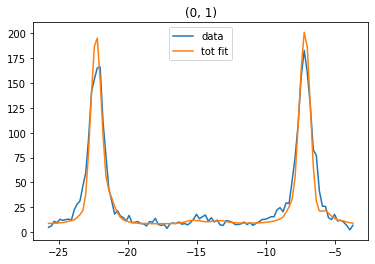

(0, 0)
                Co     Omega     Gamma         Delta            tau  \
Values    0.099174  7.482933  0.098804  1.699002e-13     313.805043   
StdErrs   0.040961  3.262128  0.043584  3.816975e+03  992202.563900   
Initials  0.086742  7.495424  0.099802  9.980193e-02       1.000000   

          delta_position  delta_width  delta_amplitude     shift    offset  
Values          2.000000     0.013245        12.842054  0.125805  2.942461  
StdErrs        19.146474     0.046596        18.245740  0.016446  6.561002  
Initials        0.624206     0.013379        12.971772  0.152199  5.144518  


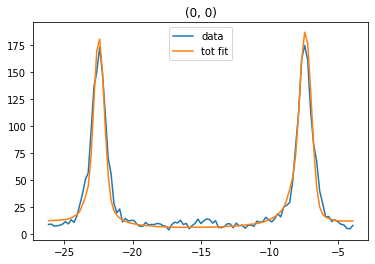

(1, 0)
                Co     Omega     Gamma        Delta            tau  \
Values    0.096093  7.479605  0.086014     4.661321      86.299283   
StdErrs   0.065362  5.136357  0.055996  9508.750965  178292.096125   
Initials  0.082975  7.492550  0.086883     0.086883       1.000000   

          delta_position  delta_width  delta_amplitude     shift    offset  
Values          2.000000     0.014150        12.762226  0.103280  5.691823  
StdErrs        19.594517     0.062214        31.440651  0.015616  8.188455  
Initials        0.624245     0.014293        12.891137  0.115592  7.891754  


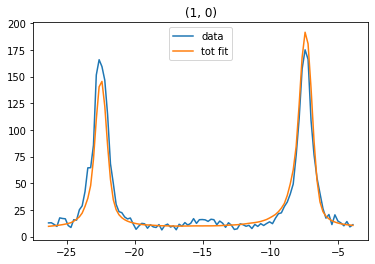

(1, 1)
                Co     Omega     Gamma         Delta            tau  \
Values    0.095869  7.477779  0.089120  4.207893e-14     189.088638   
StdErrs   0.056112  4.555796  0.052727  3.209027e+03  622027.070714   
Initials  0.083382  7.486980  0.090020  9.002019e-02       1.000000   

          delta_position  delta_width  delta_amplitude     shift    offset  
Values          2.000000     0.012954        13.349607  0.125385  5.429566  
StdErrs        23.929180     0.053314        25.462760  0.016645  7.512048  
Initials        0.624137     0.013085        13.484451  0.158643  7.554310  


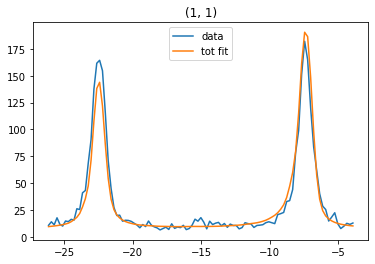

(1, 2)
                Co     Omega     Gamma      Delta        tau  delta_position  \
Values    0.101990  7.369589  0.088517   0.189459   0.528068        2.000000   
StdErrs   0.053767  3.381336  0.075872  13.193588  19.497382       36.399793   
Initials  0.085400  7.444029  0.089411   0.089411   1.000000        0.624368   

          delta_width  delta_amplitude     shift    offset  
Values       0.013107        14.799614  0.127177  5.137981  
StdErrs      0.058555        79.029750  0.016937  7.791433  
Initials     0.013240        14.949105  0.124806  7.672388  


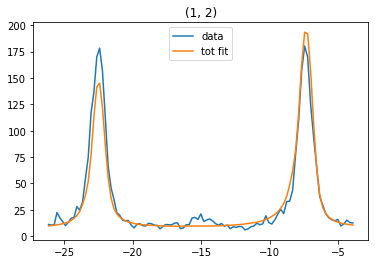

(2, 2)
                Co     Omega     Gamma     Delta        tau  delta_position  \
Values    0.102831  7.455002  0.102637  0.017817   0.217338        2.000000   
StdErrs   0.042872  1.347124  0.479279  2.853712  36.938970      109.702394   
Initials  0.087477  7.530305  0.103674  0.103674   1.000000        0.623739   

          delta_width  delta_amplitude     shift    offset  
Values       0.011840        18.110142  0.123185  4.473729  
StdErrs      0.042924       232.736970  0.017033  6.741802  
Initials     0.011960        18.293073  0.194985  6.608085  


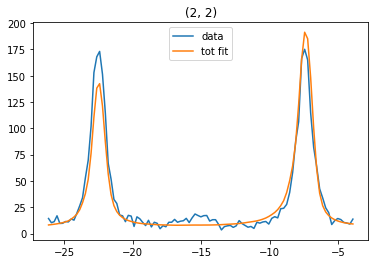

(2, 1)
                Co     Omega     Gamma     Delta        tau  delta_position  \
Values    0.100622  7.453704  0.084861  0.016918   0.131226        2.000000   
StdErrs   0.174679  0.181365  6.358965  0.326852  94.058772      145.267988   
Initials  0.085348  7.528994  0.085718  0.085718   1.000000        0.624253   

          delta_width  delta_amplitude     shift    offset  
Values       0.012472        16.389049  0.352133  4.575074  
StdErrs      0.179849       308.937446  0.016583  9.042929  
Initials     0.012598        16.554595  0.430428  6.856070  


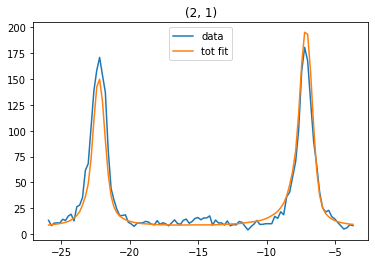

(2, 0)
                Co     Omega     Gamma      Delta        tau  delta_position  \
Values    0.105131  7.376063  0.101835   0.287581   0.732293        2.000000   
StdErrs   0.070796  4.664817  0.058692  24.002613  29.634166       35.715527   
Initials  0.088637  7.450569  0.102863   0.102863   1.000000        0.624576   

          delta_width  delta_amplitude     shift    offset  
Values       0.013040        15.068480  0.116845  3.484475  
StdErrs      0.061087        86.180330  0.016661  8.018622  
Initials     0.013172        15.220687  0.099835  6.000999  


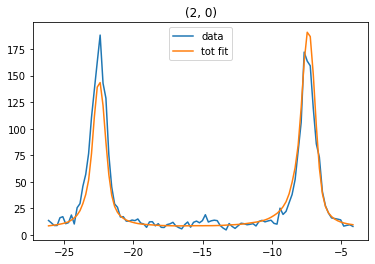

In [20]:
Plot_Elements_Spectrum(matrix, boni[0:10], fit = 'tot')

In [17]:
for (ii,jj) in boni[0:20]:
    print(matrix[ii][jj].Markov_Fit_Params)


Co     Omega     Gamma  delta_position  delta_width  \
Values    0.095121  7.502283  0.051082        0.168075     0.064783   
StdErrs   0.263560  0.025167  0.009704        2.104171     0.934160   
Initials  0.107378  7.571486  0.149129        0.119016     0.144893   

          delta_amplitude             A         mu      sigma     shift  \
Values           5.472499  4.464061e+03  -9.989592  15.784915  0.106779   
StdErrs       1098.687724  8.301768e+09  43.407259  64.849571  0.010381   
Initials         8.346143  4.797472e+03 -10.090497  15.800716  0.211020   

            offset  
Values    5.373154  
StdErrs   4.488720  
Initials -0.310388  
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.098590  7.492309  0.008292        1.439881     0.001134   
StdErrs        NaN       NaN       NaN             NaN          NaN   
Initials  0.095121  7.502283  0.051082        0.168075     0.064783   

          delta_amplitude            A         mu      sigma 